In [1]:
import pystencils as ps
import sympy as sp
from lbmpy.session import *
from lbmpy.moments import is_shear_moment, get_order

# Demo: Thermalized (Randomized) LBM

This demo notebook shows how to modify the LB collision operator to account for microscopic fluctuations. This technique is also called thermalized or randomized LBM. In these methods a random fluctuation is added to the equilibrium moments. In this simple example we implement a thermalized model by writing our own simple linear congruent random number generator, the draws indepedent random numbers on each cell. A seed is stored for each cell since all cells are processed in parallel.

## 1) Creating the method definition

In the thermalized LBM, the equilibrium values of moments are altered by small, random fluctuations. We achieve this by creating a new class to represent this randomized equilibrium, inheriting from `ContinuousHydrodynamicMaxwellian`, but overriding the computation of raw moments to insert our random numbers. The overridden equilibrium looks like this:
```python
class ThermalizedEquilibrium(ContinuousHydrodynamicMaxwellian):
    def __init__(self, random_number_symbols, **kwargs):
        super().__init__(**kwargs)
        self.random_number_symbols = random_number_symbols

    def moment(self, exponent_tuple_or_polynomial):
        value = super().moment(exponent_tuple_or_polynomial)
        if is_shear_moment(exponent_tuple_or_polynomial, dim=self.dim):
            value += self.random_number_symbols[0] * 0.001
        elif get_order(exponent_tuple_or_polynomial) > 2:
            value += self.random_number_symbols[1] * 0.001
        return value
```
We use the low-level function `create_from_equilibrium` to set up a method using this altered equilibrium. This requires also constructing a `DensityVelocityComputation` instance, and the full collision info dictionary from scratch.

In [2]:
from lbmpy.fluctuatinglb import ThermalizedEquilibrium
from lbmpy.methods import DensityVelocityComputation, CollisionSpaceInfo, create_from_equilibrium
from lbmpy.moments import get_default_moment_set_for_stencil

random_number_symbols = sp.symbols("rand_:3")

stencil = LBStencil(Stencil.D2Q9)
equilibrium = ThermalizedEquilibrium(random_number_symbols, dim=stencil.D, compressible=False, c_s_sq=sp.Rational(1,3))
cqc = DensityVelocityComputation(stencil, False, False)

# SRT-Type Collision Info
moments = get_default_moment_set_for_stencil(stencil)
r_rate = 1.8
r_rate_dict = {m : r_rate for m in moments}
c_space = CollisionSpaceInfo(CollisionSpace.RAW_MOMENTS)

thermalized_method = create_from_equilibrium(stencil, equilibrium, cqc, r_rate_dict, collision_space_info=c_space)
thermalized_method

## 2) Creating the kernel equations

Next we have to define rules how to compute the quantities $rand_0$ and $rand_1$. 
We do this using a linear congruent RNG on each cell. We pass in a seed array, and in each time step this seed array is updated with the new random numbers.

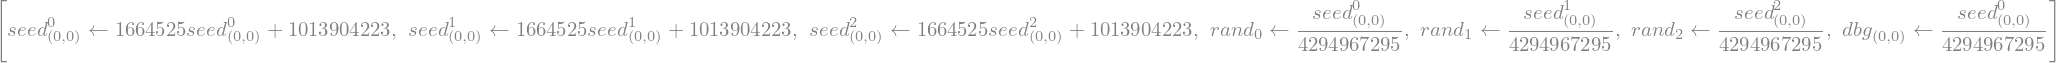

In [3]:
dh = ps.create_data_handling(domain_size=(80, 80))

seed_type = np.uint32
max_seed_type = np.iinfo(seed_type).max

# Initialize the seed array
seedField = dh.add_array('seed', dtype=seed_type, values_per_cell=len(random_number_symbols))
for b in dh.iterate():
    random_field = np.random.randint(0, high=max_seed_type, dtype=seed_type, size=b['seed'].shape)
    np.copyto(b['seed'], random_field)
    
debug_output = dh.add_array('dbg')

linear_congruent_rng_eqs = [ps.Assignment(seedField(i), seedField(i) * 1664525 + 1013904223) 
                            for i, _ in enumerate(random_number_symbols)]
floatEqs = [ps.Assignment(ps.TypedSymbol(s.name, np.float64), seedField(i) / max_seed_type)
            for i, s in enumerate(random_number_symbols)]
                      
rng_eqs = linear_congruent_rng_eqs + floatEqs + [ps.Assignment(debug_output.center, seedField(0) / max_seed_type)]
rng_eqs

These assignments are then added to the LB collision rule.

In [4]:
collision_rule = create_lb_collision_rule(lb_method=thermalized_method)
collision_rule.subexpressions = rng_eqs + collision_rule.subexpressions

In [5]:
collision_rule

"$${seed}_{(0,0)}^{0} \leftarrow 1664525 {seed}_{(0,0)}^{0} + 1013904223$$"
"$${seed}_{(0,0)}^{1} \leftarrow 1664525 {seed}_{(0,0)}^{1} + 1013904223$$"
"$${seed}_{(0,0)}^{2} \leftarrow 1664525 {seed}_{(0,0)}^{2} + 1013904223$$"
"$$rand_{0} \leftarrow \frac{{seed}_{(0,0)}^{0}}{4294967295}$$"
"$$rand_{1} \leftarrow \frac{{seed}_{(0,0)}^{1}}{4294967295}$$"
"$$rand_{2} \leftarrow \frac{{seed}_{(0,0)}^{2}}{4294967295}$$"
"$${dbg}_{(0,0)} \leftarrow \frac{{seed}_{(0,0)}^{0}}{4294967295}$$"
$$partial_{m m1 e 0} \leftarrow f_{3} + f_{5} + f_{7}$$
$$partial_{m 0 e 0} \leftarrow f_{0} + f_{1} + f_{2}$$
$$partial_{m 1 e 0} \leftarrow f_{4} + f_{6} + f_{8}$$
$$partial_{m m1 e 1} \leftarrow f_{5} - f_{7}$$


Finally, lets test our method by running a lid-driven-cavity with it.

In [6]:
ldc = create_lid_driven_cavity(data_handling=dh, collision_rule=collision_rule, lid_velocity=0.05,
                               kernel_params={'rand_0': 0, 'rand_1': 0})

In [7]:
#show_code(ldc.ast)

In [8]:
ldc.run(100)

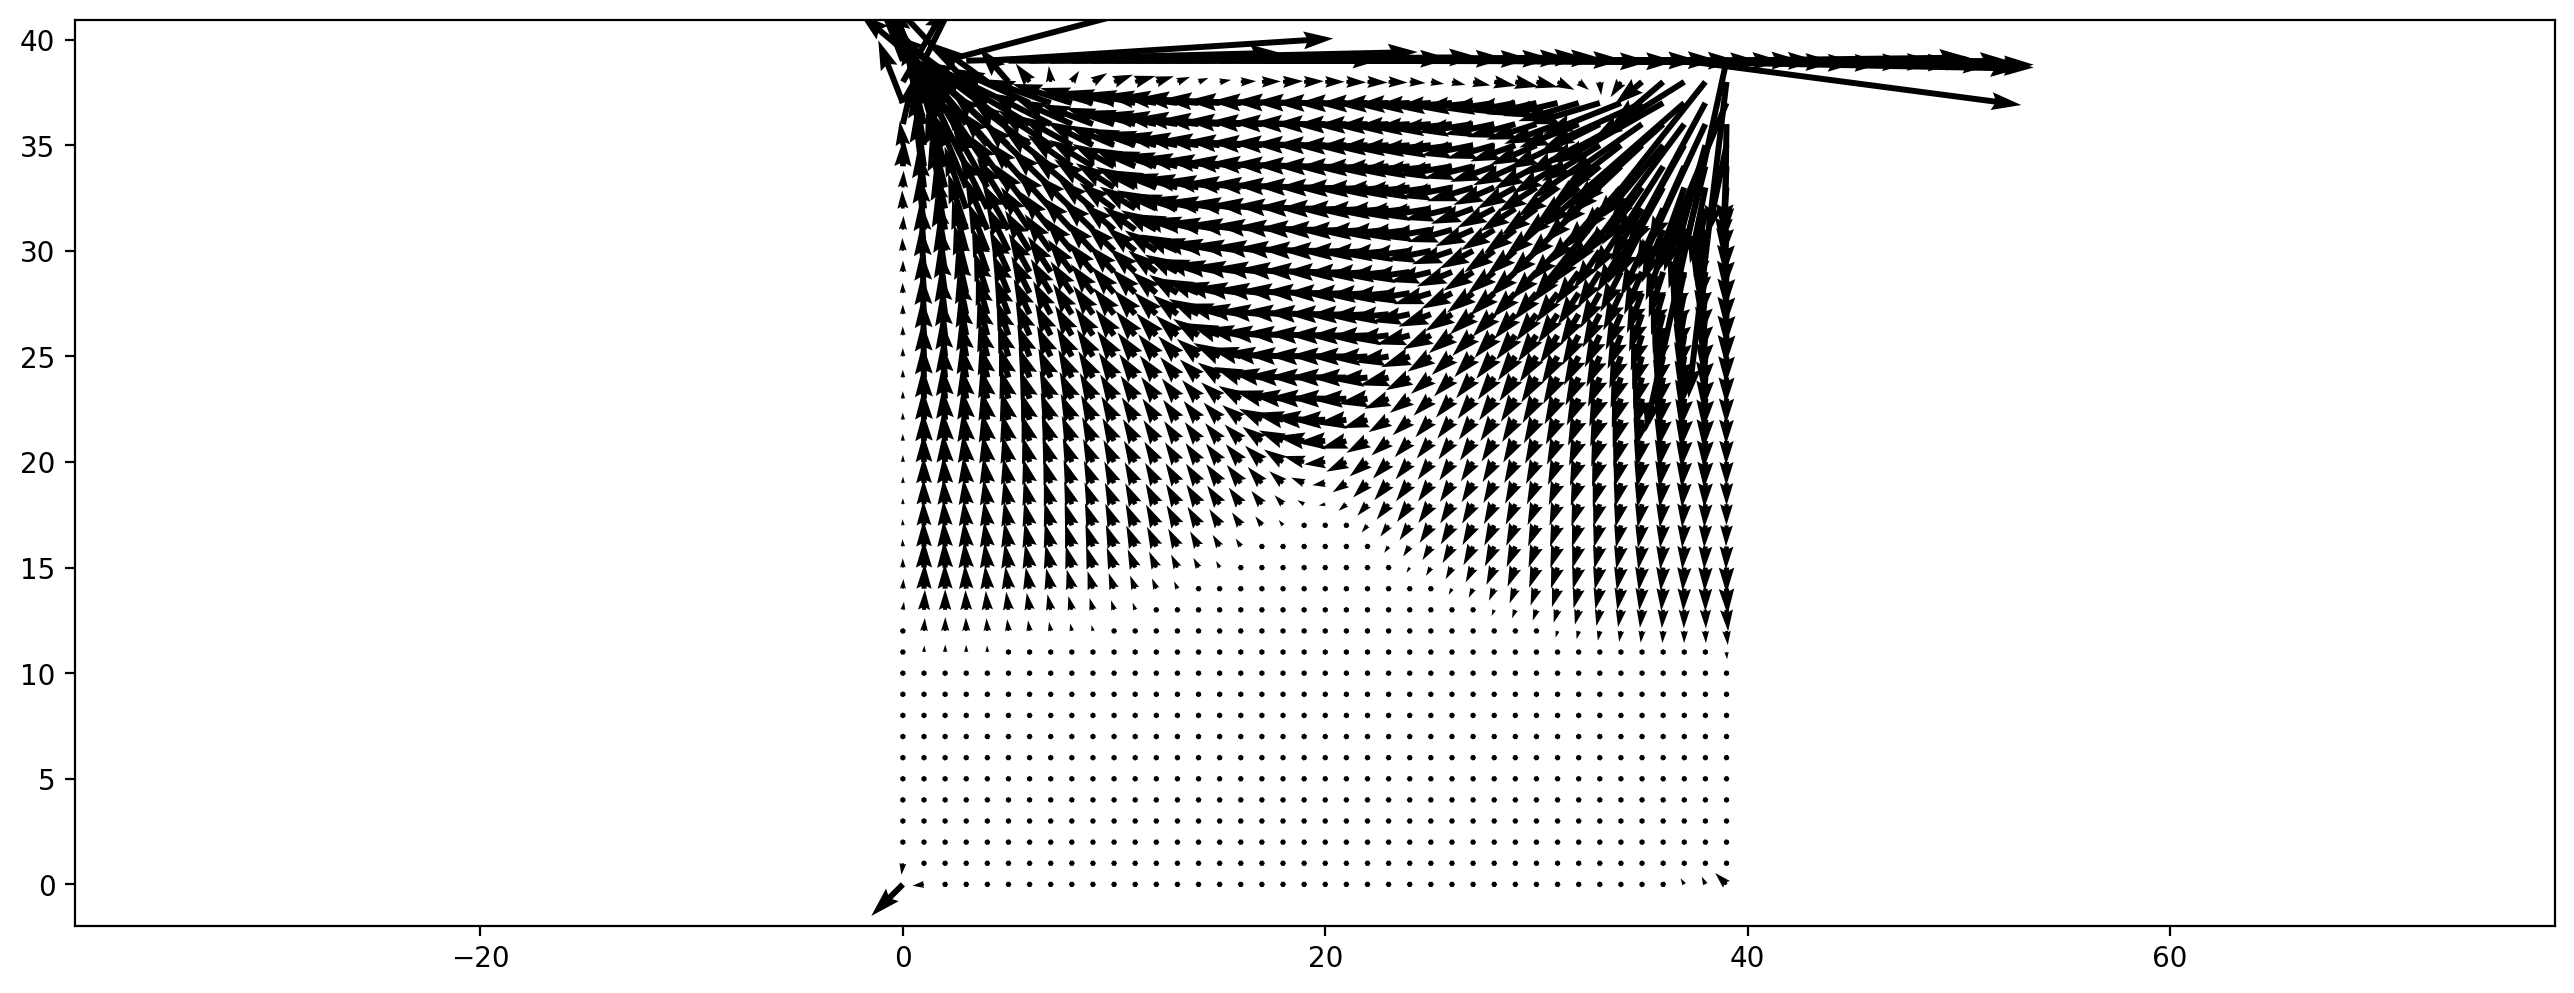

In [9]:
plt.figure(dpi=200)
plt.vector_field(ldc.velocity[:, :]);

In [10]:
assert np.isfinite(dh.max('ldc_velocity'))